Данный пример включает в себя ипользование библиотечной реализации метода CMM.

## **Тестирование метода CCM на данных теплоучета**

Для примменения метода CCM к нашим рядам установим необходимый модуль и подключим библиотеки:

In [1]:
!pip install skccm

  Created wheel for skccm: filename=skccm-0.2.dev0-cp37-none-any.whl size=12592 sha256=0f4909ba22a3bf86ab419305a9ee2eb59661f30f090ff9b6c24b179a96dad781
  Stored in directory: /root/.cache/pip/wheels/9f/23/e2/aa730525818a1dd3265f5c65edc6f1eab652e83efa14c44831
Successfully built skccm


In [2]:
import skccm as ccm
from skccm import Embed
from skccm.utilities import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import math
import pylab
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
%matplotlib inline

Загрузим наш датасет с данными по домам:

In [14]:
initial = pd.read_csv('data_distinguished.csv', sep=';', parse_dates=['Date'], decimal='.', encoding='cp1251')
df = initial.copy()
df.head()

,Unnamed: 0,Date,М1_t,М2_t,delta_М_t,Т1,Т2,delta_Т,Q,USPD,YYYYMM,registrated,scheme,type,area,floors,walls_material,year_of_construction,area_of_building,temp,Address,Number_of_inhabitants,Q_without_HW
0,0,2013-12-01,93.950333,84.168098,9.782235,65.859886,43.560223,22.299663,2.104783,1,201312,Heating + Hot water,opened,1105,2707.4,5,panel,1983,4401.0,-0.157917,"Иркутский тр. , д.196",102.0,1.170587
1,1,2013-12-01,169.336258,169.643768,-0.307510,66.641441,49.602718,17.038723,2.892227,3,201312,Heating + Hot water,closed,2105,3358.4,5,brick,1974,3610.4,-0.157917,"Иркутский тр. , д.104-а",133.0,1.674108
2,2,2013-12-01,98.604866,100.520248,-1.915382,67.661072,41.020565,26.640507,2.630709,4,201312,Heating + Hot water,closed,2105,3153.5,5,brick,1975,3150.2,-0.157917,"Иркутский тр. , д.108",119.0,1.540813
3,3,2013-12-01,121.030000,115.590000,5.440000,66.470000,50.350000,16.120000,1.949000,10,201312,Heating + Hot water,opened,1105,2646.5,5,panel,1982,2932.7,-0.157917,"Фрунзе пр. , д.67/1",100.0,1.033121
4,4,2013-12-01,100.120705,102.018661,-1.897956,67.699661,40.780910,26.918751,2.698659,12,201312,Heating + Hot water,closed,2105,3187.5,5,brick,1976,3456.2,-0.157917,"Иркутский тр. , д.114",132.0,1.489699


Прежде чем применить метод CCM к данным, необходимо определить функции нахождения оптимальных параметров вложения (embedding) для дальнейшего построения лагового пространства (shadow manifold).

[Introduction to Taken's Embedding](https://www.kaggle.com/tigurius/introduction-to-taken-s-embedding/notebook)



### **Функция для определение оптимального значения задержки (delay)**

In [3]:
# Считаем взаимуню информацию по заданной задержке

def calc_MutualInformation(signal, delay, nBins, verbose):
    I = 0
    xmax = np.max(signal)
    xmin = np.min(signal)
    
    signalDelay = signal[delay:len(signal)] # все точки, кроме первой задержки
    signalOriginal = signal[0:len(signal)-delay] # кроме последней задержки

    binsize = np.abs(xmax - xmin) / nBins
    
    # словари для ускорения процесса
    probInBin = {} # P_k
    # P_hk
    conditionBin = {}
    conditionDelayBin = {}
    
    for h in range(0, nBins):
        if h not in probInBin:
            conditionBin.update({h : (signalOriginal >= (xmin+h*binsize)) & (signalOriginal < (xmin+(h+1)*binsize))})
            probInBin.update({h : len(signalOriginal[conditionBin[h]]) / len(signalOriginal)})
        for k in range(0, nBins):
            if k not in probInBin:
                conditionBin.update({k : (signalOriginal >= (xmin+k*binsize)) & (signalOriginal < (xmin+(k+1)*binsize))})
                probInBin.update({k : len(signalOriginal[conditionBin[k]]) / len(signalOriginal)})
            if k not in conditionDelayBin:
                conditionDelayBin.update({k : (signalDelay >= (xmin+k*binsize)) & (signalDelay < (xmin+(k+1)*binsize))})
            Phk = len(signalOriginal[conditionBin[h] & conditionDelayBin[k]]) / len(signalOriginal)
            if Phk != 0 and probInBin[h] != 0 and probInBin[k] != 0:
                I -= Phk * math.log(Phk / (probInBin[h]*probInBin[k]))

    return I

### **Функция для определения оптимальной размерности**



In [4]:
def computeFNN(signal, delay, dimension, R_thr=10):
    embeddedData = np.array([signal[0:len(signal)-delay*dimension]])
    for i in range(1, dimension):
      embeddedData = np.append(embeddedData, [signal[i*delay:len(signal) - delay*(dimension-i)]], axis=0)
    embSig = embeddedData.transpose()

    # т.к. 1й ближайший сосед - сама точка ряда, то берем 2го ближайшего соседа
    nbr = NearestNeighbors(n_neighbors=2).fit(embSig)

    # ищем k ближайших соседа точки
    distance, index = nbr.kneighbors(embSig) # возвращает расстояния до соседей каждой точки и индексы соседей

    epsilon = np.std(distance.flatten())
    distDiff = np.diff(distance) # разность между последовательными элементами

    nFNN = 0
    # ищем количество ложных ближайших соседей
    for i in range(0, len(signal)-delay*(dimension+1)):
        if distance[i,1] == 0: # во избежание деления на ноль
            R = abs(signal[i+dimension*delay] - signal[index[i,1]+dimension*delay]) / 0.01 # нормализуем расстояние
        else:
            R = abs(signal[i+dimension*delay] - signal[index[i,1]+dimension*delay]) / distance[i,1] # нормализуем расстояние
        if (0 < distDiff[i+1]) and (distDiff[i+1] < epsilon) and (R > R_thr):
            nFNN += 1

    return nFNN

### **Определение оптимальных значений задержки и размерности**

In [5]:
def find_lag_opt(nDelay, signalX, signalY, nBins, verbose=0):
    delay_vector = np.arange(1, nDelay + 1)
    info_vectorX = []
    info_vectorY = []
    
    for i in delay_vector:
        info_vectorX = np.append(info_vectorX, [calc_MutualInformation(signalX, i, nBins, verbose=verbose)])
        info_vectorY = np.append(info_vectorY, [calc_MutualInformation(signalY, i, nBins, verbose=verbose)])
     
    idx_minI_X = np.argmin(info_vectorX)
    idx_minI_Y = np.argmin(info_vectorY)
    
    lag_optX = delay_vector[idx_minI_X]
    lag_optY = delay_vector[idx_minI_Y]
    
    return lag_optX, lag_optY

In [6]:
def find_dim_opt(nDim, signalX, signalY, tauX, tauY):
    dim_range = np.arange(1, nDim+1)
    num_FNN_X = []
    num_FNN_Y = []
    
    for i in dim_range:
        num_FNN_X = np.append(num_FNN_X, [computeFNN(signalX, tauX, i)])
        num_FNN_Y = np.append(num_FNN_Y, [computeFNN(signalY, tauY, i)])
        
    idx_minDim_X = np.argmin(num_FNN_X)
    idx_minDim_Y = np.argmin(num_FNN_Y)
    
    dim_optX = dim_range[idx_minDim_X]
    dim_optY = dim_range[idx_minDim_Y]
    
    return dim_optX, dim_optY

### **Применение метода CCM**

Необходимо понять, насколько динамическое поведение ряда для потребления тепловой энергии зависимо от внешней температуры.

In [7]:
def compute_CCM(x1, x2, nDelay, nDim, nBins=100):
  """
    Функция реализует метод ССМ для двух рядов x1, x2 по заданным начальным параметрам задержки и размерности

    Parameters
    ----------
    x1: 1d array
        исходные данные
    
    x2: 1d array
        исходные данные

    nDelay: int
        максимально возможная задержка
    
    nDim: int
        максимально возможная размерность пространства

    nBins: int
        количество сегментов данных

    Returns
    -------
    sc1: 2d array
        коэфициенты корреляции CCM: Cxy

    sc2: 2d array
        коэфициенты корреляции CCM: Cyx
  """

  if nDelay*nDim > len(x1) or nDelay*nDim > len(x2):
    raise NameError('Ошибка! Задержка*размерность превышает длину временного ряда. Измените параметры!')

  # ищем оптимальные значения задержки
  lagX, lagY = find_lag_opt(nDelay, x1, x2, nBins)
  lag = lagX

  # ищем оптимальные значения размерностей эмбэддингов
  dim_optX, dim_optY = find_dim_opt(nDim, x1, x2, lagX, lagY)

  # проверка, что два лаговых пространства (shadow manifolds) имеют одинаковую размерность
  if dim_optX != dim_optY:
    embed = max(dim_optX, dim_optY)
  else:
    embed = dim_optX

   # ищем оптимальные значения задержки
  lagX, lagY = find_lag_opt(nDelay, x1, x2, nBins)
  lag = lagX

  # ищем оптимальные значения размерностей эмбэддингов
  dim_optX, dim_optY = find_dim_opt(nDim, x1, x2, lagX, lagY)

  # проверка, что два лаговых пространства (shadow manifolds) имеют одинаковую размерность
  if dim_optX != dim_optY:
    embed = max(dim_optX, dim_optY)
  else:
    embed = dim_optX
  
  #print('Оптимальное значение задержки для Mx и My: ', lag)
  #print('Оптимальное значение размерности для Mx и My: ', embed)

  # строим эмбэддинги временных рядов по заданным параметрам
  e1 = ccm.Embed(x1)
  e2 = ccm.Embed(x2)
  # переводим векторы из одномерного временного ряда в m-мерное пространство (т.е. строим лаговое пространтсво)
  X1 = e1.embed_vectors_1d(lag,embed)
  X2 = e2.embed_vectors_1d(lag,embed)

  # разбиваем ряды на обучающую и тестовую выборки
  x1_train, x1_test, x2_train, x2_test = train_test_split(X1, X2, percent=.75)
  CCM = ccm.CCM() # инициализируем класс CCM
  # задаем количество измерений: берем 50 точек от embed+1 до длины x1tr
  lib_lens = np.arange(embed+1, len(x1_train), len(x1_train)/50, dtype='int')
  # обучаем CCM и считаем коэфициенты корреляции
  CCM.fit(x1_train, x2_train)
  x1p, x2p = CCM.predict(x1_test, x2_test, lib_lengths=lib_lens)
  sc1,sc2 = CCM.score()

  return sc1, sc2

Т.к. будем сравнивать дома с разными характеристиками, вынсесем для удобства в отдельную функцию код для отрисовки рядов и коэффициентов корреляции. Если во временном ряде имеется длинный участок с константами, то обрежем его (параметр check_null).

Нам интересно не только сравнивать дома между собой, но и сравнивать ряды для разных USPD одного дома, для такой задачи введем параметр uspd, который позволит сделать другое разбиение датасета.

In [8]:
def plot_CCM(adress, check_null = False, plot = True, uspd = 0, scaler=True):
  """
    Функция реализует метод ССМ для двух рядов T и Q для одного конкретного дома по адресу adress

    Parameters
    ----------
    adress: list
        список с одним элементом - адресом дома
    
    check_null: bool
        необходимо ли обрезать константы в конце ряда

    plot: bool
        необходимо ли отрисовывать графики рядов и Cxy c Сух
    
    uspd: int
        для задачи сравнения рядов для разных USPD одного дома
    
    scaler: bool
        необходимо ли нормировать ряды

    Returns
    -------

    sc2: 2d array
        коэфициенты корреляции CCM: Cyx
  """
  scaler = StandardScaler() #для нормирования рядов
  
  one_house = df.loc[df['Address'].isin(adress)] # все параметры конертеного дома

  if uspd!=0:
    one_house = one_house[(one_house.USPD == uspd)]

  if check_null == False: # берем все данные
    x1 = np.asarray(one_house.loc[:, 'temp']) # только температура 
    x2 = np.asarray(one_house.loc[:, 'Q']) # только теплопотребление
    t = np.asarray(one_house.loc[:, 'Date']) # дата
  else: # иначе - обрезаем константы
    x1 = np.asarray(one_house.loc[:, 'temp'][:750]) # только температура 
    x2 = np.asarray(one_house.loc[:, 'Q'][:750]) # только теплопотребление
    t = np.asarray(one_house.loc[:, 'Date'][:750]) # дата

  if scaler==True:
    # нормируем ряды
    x1 = scaler.fit_transform(x1.reshape(-1, 1)).transpose()[0]
    x2 = scaler.fit_transform(x2.reshape(-1, 1)).transpose()[0]

  # задаем начальные параметры
  l = min(len(x1), len(x2))
  nDelay = int(np.sqrt(l)) # максимально возможная задержка
  nBins = 100 # количество сегментов данных
  nDim = int(np.sqrt(l)) # максимально возможная размерность пространства
  # задаем их так, чтобы задержка*размерность не превышала длину временного ряда
  
  # примением ССМ
  sc1, sc2 = compute_CCM(x1, x2, nDelay, nDim, nBins)

  if plot == True: # если нужна отрисовка
    print("\033[1m", adress[0])

    # строим нормированные ряды
    plt.figure(figsize=(10,5))
    plt.plot(t, x1)
    plt.plot(t, x2)
    plt.tick_params(axis='y', which='major', labelsize=16)
    plt.tick_params(axis='x', which='major', labelsize=10)
    plt.title('Нормированные временные ряды для дома '+str(adress[0]), fontsize = 15)
    plt.xlabel('Дата', fontsize = 15)
    plt.legend(['T', 'Q'], loc = 'best')
    plt.show()

    # выводим среднее по коэфициентам корреляции CCM
    # (среднее берем начиная с 10 отсчета)
    print("Коэфициенты корреляции CCM рядов:\nCxy = {}\nCyx = {}\n\n".format(np.mean(sc1[10:]),np.mean(sc2[10:])))
    
    # строим зависимость коэфициентов корреляции CCM от длины выборки
    plt.figure(figsize=(10,5))
    plt.plot(sc1)
    plt.plot(sc2)
    plt.tick_params(axis='y', which='major', labelsize=15)
    plt.tick_params(axis='x', which='major', labelsize=15)
    plt.xlabel('номер измерений', fontsize = 15)
    plt.ylabel('коэфициенты корреляции CCM', fontsize = 15)
    plt.legend(['Cxy', 'Cyx'], loc = 'best')
    plt.show()

  return sc2 # возвращаем Cyx

Создадим словать, где ключ - адрес дома, значение - массив из коэффициентов корреляции $C_{YX}$ для дома:

In [9]:
dict_adress_Cyx = {}

Вынесем отдельно в функцию применение ССМ для нескольких домов + отрисовку коэффицикнтов Сух для них.

In [10]:
def teplouchet_check(adress, check_null=False, plot = True, scaler=True):
  """
    Функция применения ССМ к нескольким домам из списка адресов и отображения их коэффициентов Сух

    Parameters
    ----------
    adress: list
        список с адресами
    
    check_null: bool
        необходимо ли обрезать константы в конце ряда
    
    plot: bool
        необходимо ли отрисовывать графики рядов и Cxy c Сух
        
    scaler: bool
        необходимо ли нормировать ряды
  """
  # Список для сохранения коэффициентов Сух
  Cyx_coeffs = []
  for i, adr in enumerate(adress): # проходимся по всем адресам в списке и сохраняем их коэффициенты Сух
    Cyx_coeffs.append(plot_CCM([adr], check_null=check_null, plot=plot, scaler=scaler))
    dict_adress_Cyx[adr] = Cyx_coeffs[i] # добавляем в словарь запись вида 'адрес': список коэффициентов Сух

  # если в функцию передано более одного адреса, то нарисуем сравнение по коэффициентам Сух для всех домов
  if len(adress) > 1:
    pylab.figure(figsize=(10,5))
    for i in range(len(Cyx_coeffs)):
      pylab.plot(Cyx_coeffs[i], label = 'Cyx '+str(adress[i]))
    plt.title('Сравнение коэффициентов Сyx двух домов', fontsize = 15, weight='bold')
    pylab.xlabel('номер измерений', fontsize = 15)
    pylab.ylabel('коэфициенты корреляции Cyx', fontsize = 15)
    plt.tick_params(axis='y', which='major', labelsize=15)
    plt.tick_params(axis='x', which='major', labelsize=15)
    pylab.legend ()
    pylab.show()

Рассмотрим дом по адресу Сибирская 33. Он примечателен тем, что частично горел в результате взрыва газового баллона. Посмотрим, проявилось ли это в наших рядах.

 Сибирская ул. , д.33


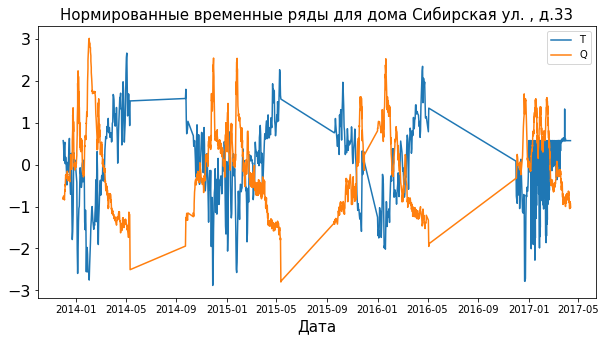

Коэфициенты корреляции CCM рядов:
Cxy = 0.44173997401055437
Cyx = 0.806295238923442




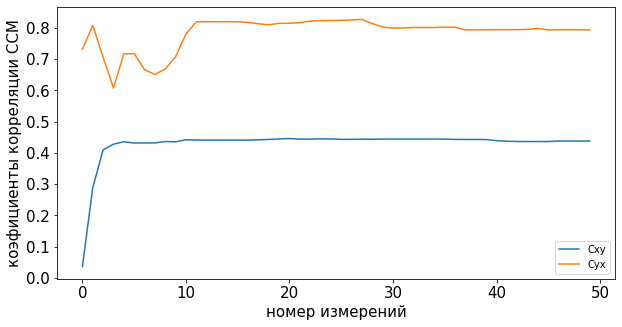

In [ ]:
adress = ['Сибирская ул. , д.33']
teplouchet_check(adress)

Сравним 5-этажный кирпичный дом 1959-го года (Большая-Подгорная 42) с 2-этажным деревянным 1887-го года (Гагарина 40):

 Большая-Подгорная ул. , д.42


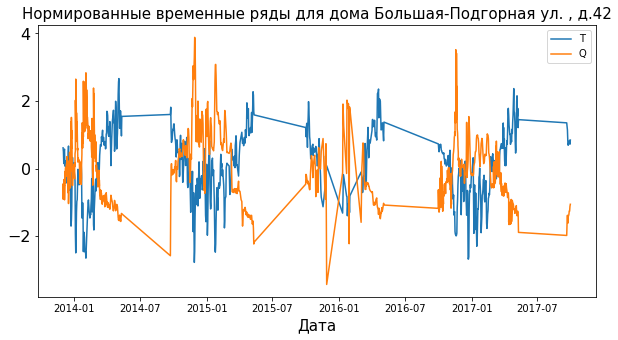

Коэфициенты корреляции CCM рядов:
Cxy = 0.795953549587912
Cyx = 0.8440885900897299




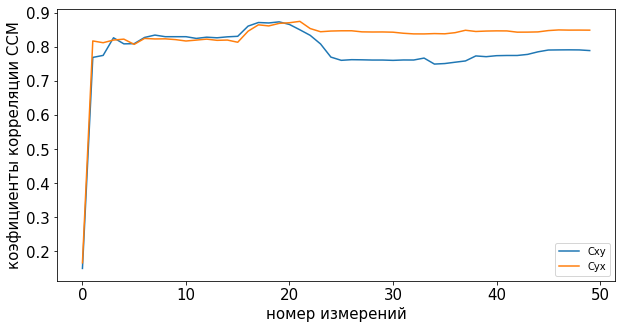

 Гагарина ул. , д.40


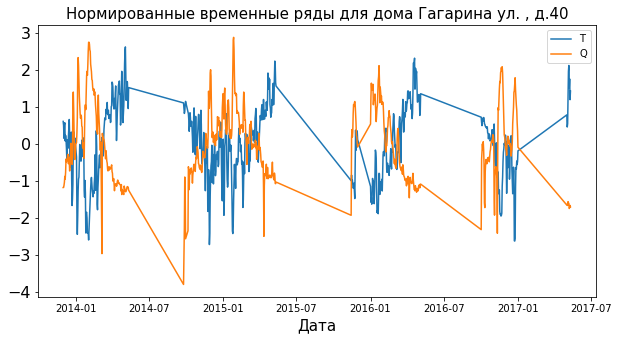

Коэфициенты корреляции CCM рядов:
Cxy = 0.8318802220978083
Cyx = 0.8088902360745569




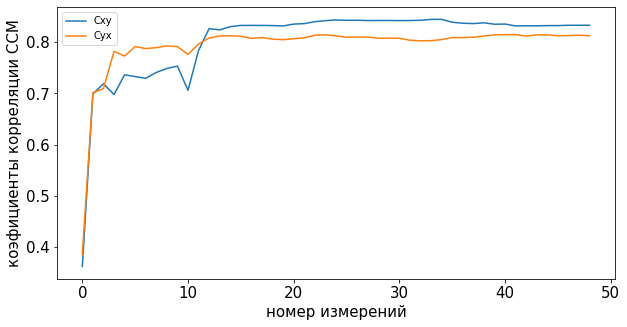

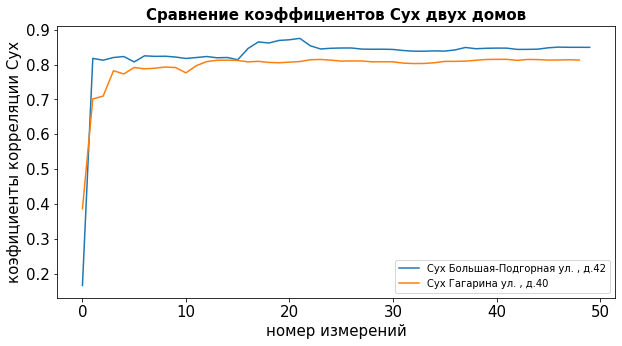

In [ ]:
adress = ['Большая-Подгорная ул. , д.42', 'Гагарина ул. , д.40']
teplouchet_check(adress)

Сравним 5-этажный монолитный дом 1993-го года (Ботанический пер 7) с 5-этажным панельным 1985-го года (Интернационалистов 36):

 Ботанический пер. , д.7


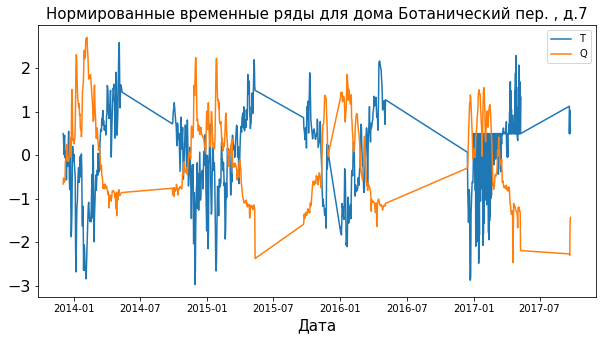

Коэфициенты корреляции CCM рядов:
Cxy = 0.5610244140738763
Cyx = 0.6671028159086851




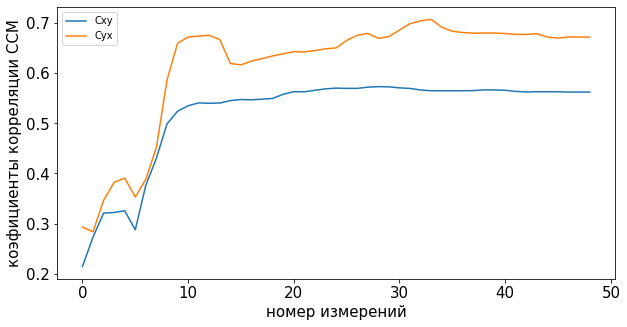

 Интернационалистов ул. , д.36


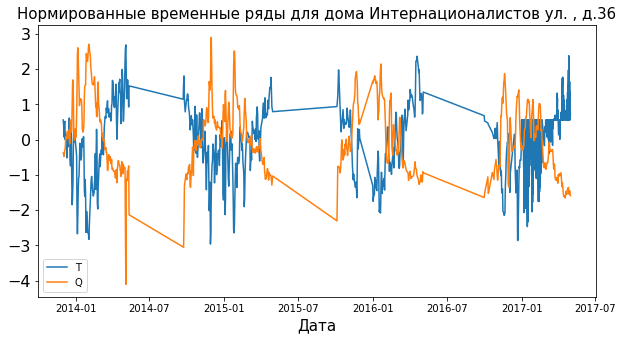

Коэфициенты корреляции CCM рядов:
Cxy = 0.5263781905905406
Cyx = 0.6705489793557199




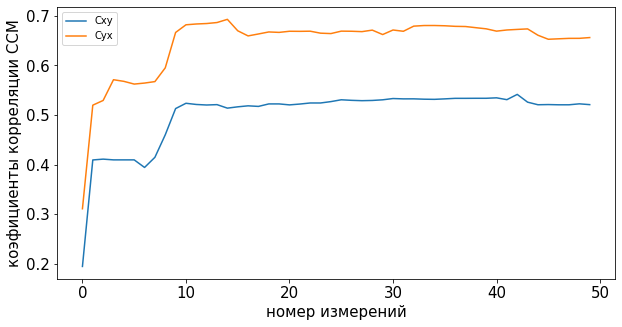

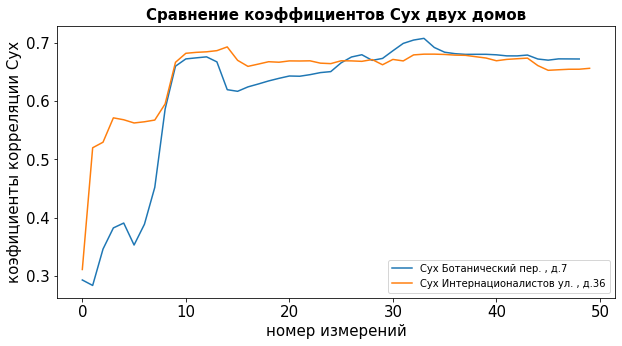

In [ ]:
adress = ['Ботанический пер. , д.7', 'Интернационалистов ул. , д.36']
teplouchet_check(adress, check_null=True)

Сравним 5-этажный кирпичный дом 1959-го года (Кирова 34) с 5-этажным панельным 1971-го года (79 Гвардейской дивизии 26):

 Кирова пр. , д.34


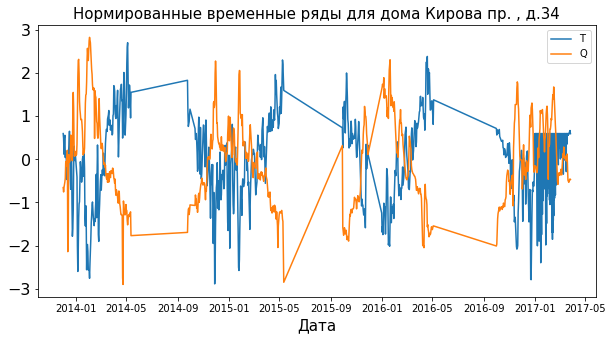

Коэфициенты корреляции CCM рядов:
Cxy = 0.3899408893728751
Cyx = 0.4160672941761511




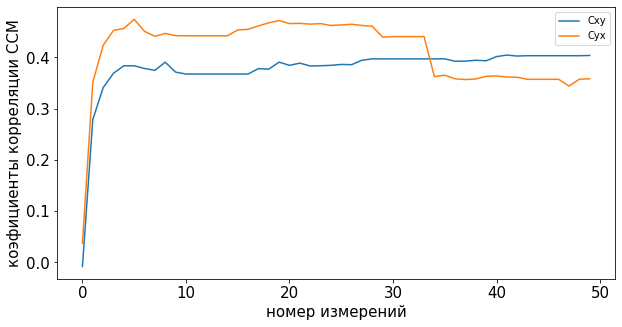

 79 Гвардейской дивизии ул. , д.26


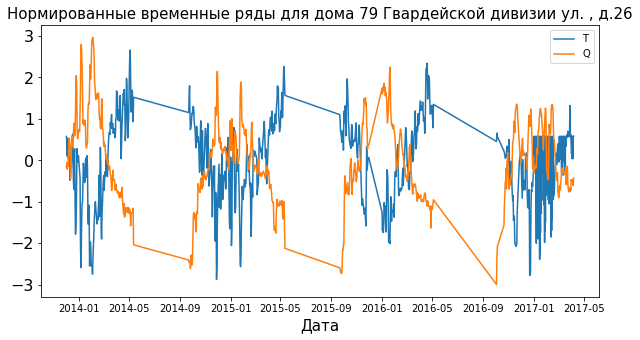

Коэфициенты корреляции CCM рядов:
Cxy = 0.4921599494943468
Cyx = 0.5391515625911708




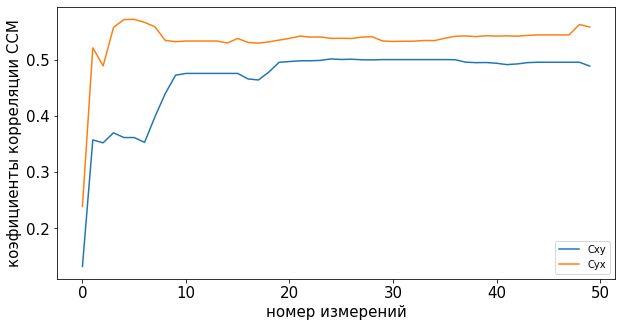

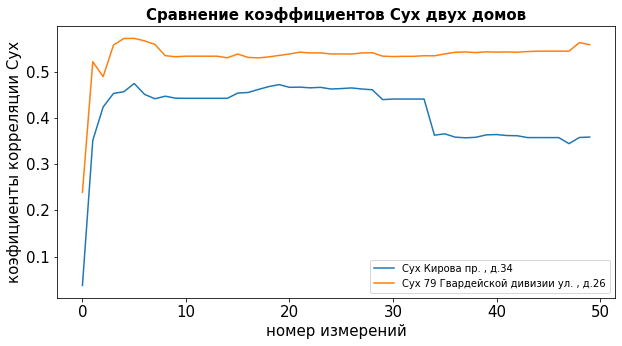

In [ ]:
adress = ['Кирова пр. , д.34', '79 Гвардейской дивизии ул. , д.26']
teplouchet_check(adress, check_null=True)

9-этажный кирпичный дом 1991-года с баней на первом этаже: 

 Говорова ул. , д.86


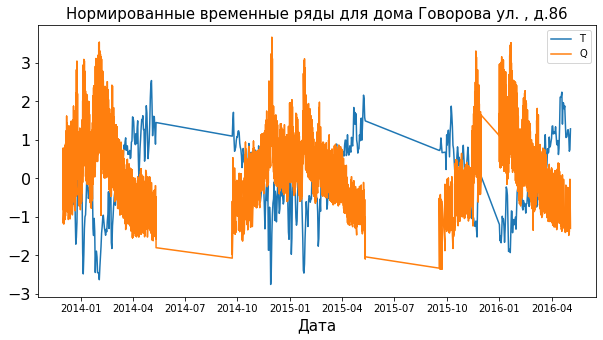

Коэфициенты корреляции CCM рядов:
Cxy = 0.8743352989150995
Cyx = 0.706691362568203




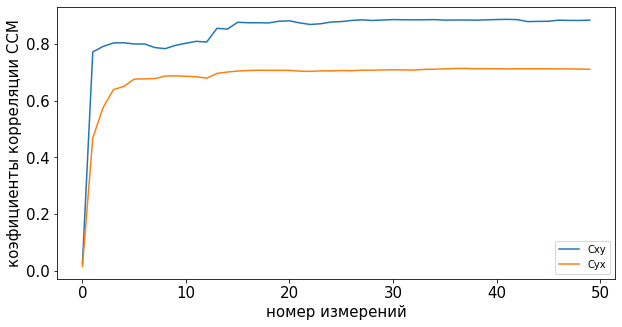

In [ ]:
adress = ['Говорова ул. , д.86']
teplouchet_check(adress)

Ненормированные ряды для этого дома:

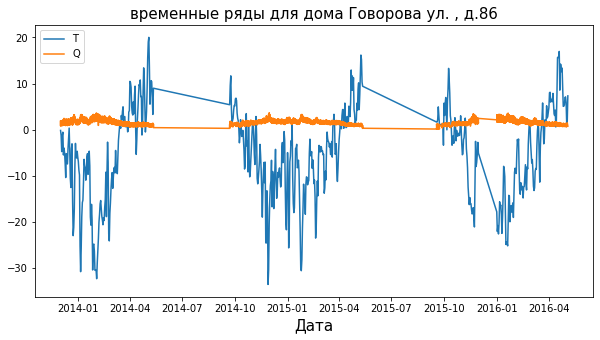

In [ ]:
one_house = df.loc[df['Address'].isin(adress)] # все параметры конертеного дома
x1 = np.asarray(one_house.loc[:, 'temp']) # только температура 
x2 = np.asarray(one_house.loc[:, 'Q']) # только теплопотребление
t = np.asarray(one_house.loc[:, 'Date']) # дата

plt.figure(figsize=(10,5))
plt.plot(t, x1)
plt.plot(t, x2)
plt.title('временные ряды для дома '+str(adress[0]), fontsize = 15)
plt.xlabel('Дата', fontsize = 15)
plt.legend(['T', 'Q'], loc = 'best')
plt.show()

**Боксплоты и коэффициенты $C_{YX}$ для домов с закрытой схемой отопления:**

Нам интересно не только сравнивать дома между собой, но и сравнивать ряды для разных USPD одного дома, для такой задачи введем функцию CMM_USPD_one_house:

In [11]:
def CMM_USPD_one_house(adress, check_null=False, scaler=True):
  """
    Функция применения ССМ к рядам для конкретного значения USPD дома и отображения их коэффициентов Сух,
    а так же оптимальных значений задержки и размерности лагового пространства

    Parameters
    ----------
    adress: list
        список с адресом
    
    check_null: bool
        необходимо ли обрезать константы в конце ряда
    
    scaler: bool
        необходимо ли нормировать ряды
  """
  one_house = df.loc[df['Address'].isin(adress)]
  Uniq_uspd = one_house.USPD.unique()

  # Список для сохранения коэффициентов Сух
  Cyx_coeffs = []
  for i, uspd in enumerate(Uniq_uspd): # проходимся по всем USPD дома
    Cyx_coeffs.append(plot_CCM(adress, check_null=check_null, plot=False, uspd=uspd, scaler=scaler))

  # рисуем графики Сyx для USPD по дому
  pylab.figure(figsize=(10,5))
  for i in range(len(Cyx_coeffs)):
    pylab.plot(Cyx_coeffs[i], label = 'Cyx '+str(Uniq_uspd[i]))
  plt.title('Сравнение коэффициентов Сyx для USPD по дому '+str(adress[0]), fontsize = 15, weight='bold')
  pylab.xlabel('номер измерений', fontsize = 15)
  pylab.ylabel('коэфициенты корреляции Cyx', fontsize = 15)
  plt.tick_params(axis='y', which='major', labelsize=15)
  plt.tick_params(axis='x', which='major', labelsize=15)
  pylab.legend ()
  pylab.show()

  # выводим средние значения Сyx для USPD по дому
  for i, uspd in enumerate(Uniq_uspd):
    print('Средний Cyx для {} = {}'.format(uspd, np.mean(Cyx_coeffs[i][10:])))

Функция для построения боксплотов и графиков для Cyx по домам/по USPD (для этой задачи параметр uspd):

In [13]:
def boxplots_and_Cyx(adresses, check_null = False, by=['Address'], uspd=False, scaler=True):
  """
    Функция строит боксплоты (ящики с усами) для домов из списка адресов,
    выводит для них средние коэффициенты Сух

    Parameters
    ----------
    adresses: list
        список с адресами
    
    check_null: bool
        необходимо ли обрезать константы в конце ряда

    by: list
        столбец в датасете для pandas.DataFrame.groupby()
        каждый боксплот будет сделан для значения столбца изи by
    
    uspd: bool
        =True, если решаем задачу разных USPD для одного дома
    
    scaler: bool
        необходимо ли нормировать ряды
  """
  # выбираем из нашего датасета информацию только по нужным адресам
  df1 = df.loc[df['Address'].isin(adresses)]

  # строим боксплоты
  _, ax = plt.subplots(figsize = (15, 7))
  plt.tick_params(axis='y', which='major', labelsize=16)
  plt.tick_params(axis='x', which='major', labelsize=13.5)
  df1.boxplot(ax = ax, column=['Q'], by=by)
  ax.set_xlabel(str(by[0]), fontsize = 13)
  ax.set_ylabel('Теплопотребление, Q', fontsize = 16)
  if uspd==False:
    ax.set_title('Теплопотребления домов по адресам', fontsize = 20)
  else:
    ax.set_title('Теплопотребления по счетчикам дома '+str(adresses), fontsize = 20)
  plt.show()

  # выводим средние Cyx для каждого дома
  for adr in adresses:
    dict_adress_Cyx[adr] = plot_CCM([adr], check_null=check_null, plot = False, scaler=scaler)
    print('Средний Cyx для {} = {}'.format(adr, np.mean(dict_adress_Cyx[adr][10:])))
  
  if uspd==False:
    # строим графики для Cyx для всех домов
    if len(adresses) > 1:
      pylab.figure(figsize=(10,5))
      for adr in adresses:
        pylab.plot(dict_adress_Cyx[adr], label = 'Cyx '+str(adr))
      plt.title('Сравнение коэффициентов Сyx домов', fontsize = 15, weight='bold')
      pylab.xlabel('номер измерения', fontsize = 15)
      pylab.ylabel('коэфициенты корреляции Cyx', fontsize = 15)
      plt.tick_params(axis='y', which='major', labelsize=15)
      plt.tick_params(axis='x', which='major', labelsize=15)
      pylab.legend ()
      pylab.show()
  else:
    # строим графики для Cyx для всех USPD дома
    CMM_USPD_one_house(adresses, check_null=check_null)

Сравним боксплоты для 5-ти кирпичных и 5 -ти панельных домов, у всех них 5 этажей, площадь около $3000 м^2$.

**Кирпичные дома**

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


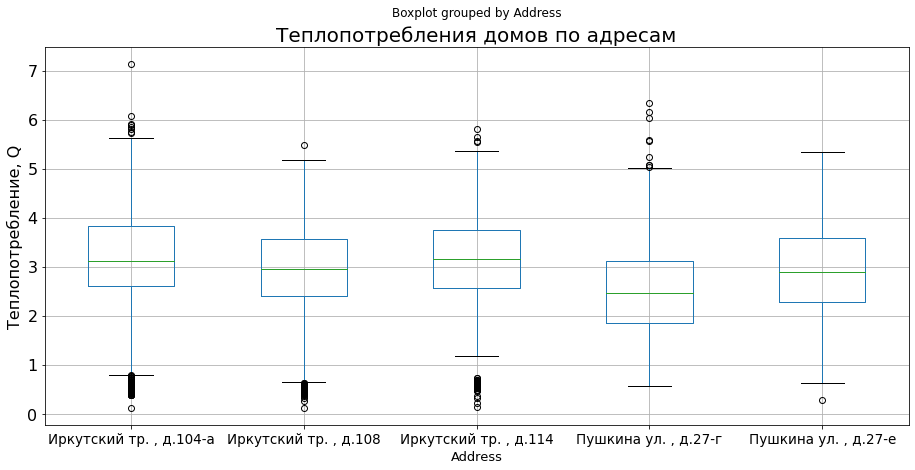

Средний Cyx для Иркутский тр. , д.104-а = 0.5605453007760477
Средний Cyx для Иркутский тр. , д.108 = 0.6851171836207783
Средний Cyx для Иркутский тр. , д.114 = 0.6862229156492831
Средний Cyx для Пушкина ул. , д.27-г = 0.7126752962671932
Средний Cyx для Пушкина ул. , д.27-е = 0.5493460027396293


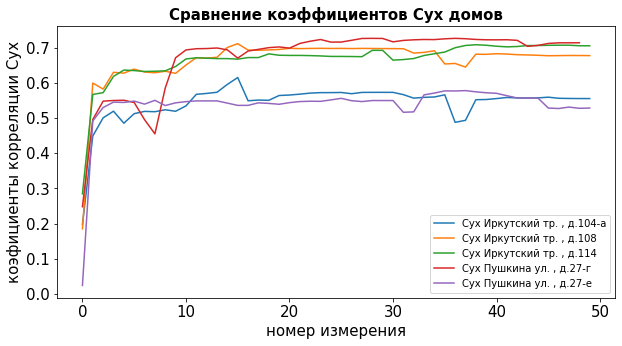

In [15]:
adresses1 = ['Иркутский тр. , д.104-а', 'Иркутский тр. , д.108', 'Иркутский тр. , д.114', 'Пушкина ул. , д.27-г', 'Пушкина ул. , д.27-е']
boxplots_and_Cyx(adresses1, check_null=True)

**Панельные дома**

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


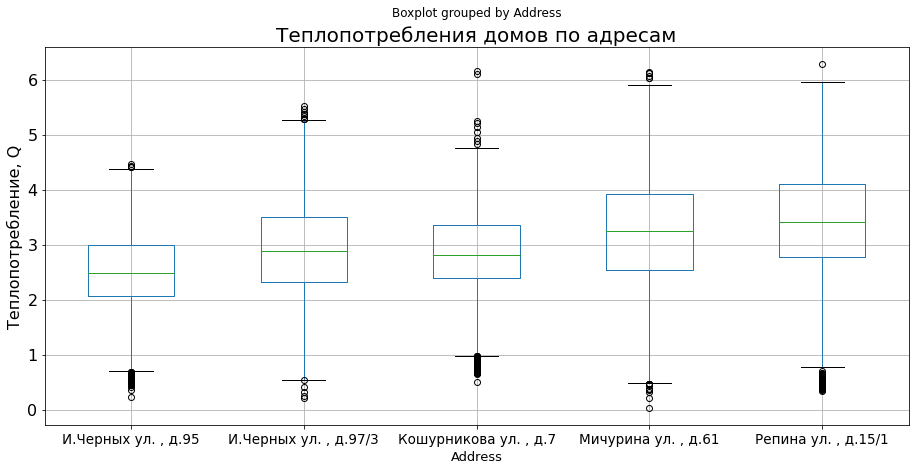

Средний Cyx для И.Черных ул. , д.95 = 0.6864698862151328
Средний Cyx для И.Черных ул. , д.97/3 = 0.737897084685778
Средний Cyx для Кошурникова ул. , д.7 = 0.6309562709074104
Средний Cyx для Мичурина ул. , д.61 = 0.40489531013926366
Средний Cyx для Репина ул. , д.15/1 = 0.5047257984432626


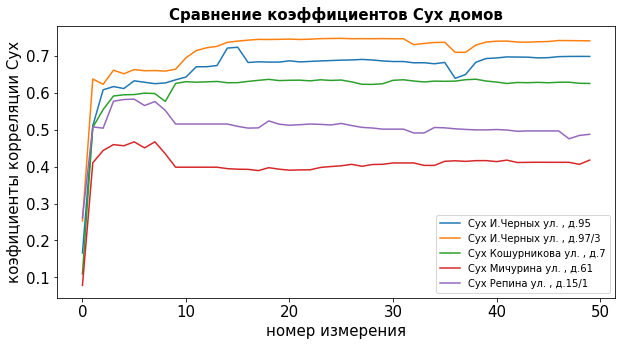

In [16]:
adresses2 = ['И.Черных ул. , д.95', 'И.Черных ул. , д.97/3', 'Кошурникова ул. , д.7', 'Мичурина ул. , д.61', 'Репина ул. , д.15/1']
boxplots_and_Cyx(adresses2, check_null=True)

**Дерево, панелька, кирпич, монолит: 5 этажей, площадь около 3000**

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


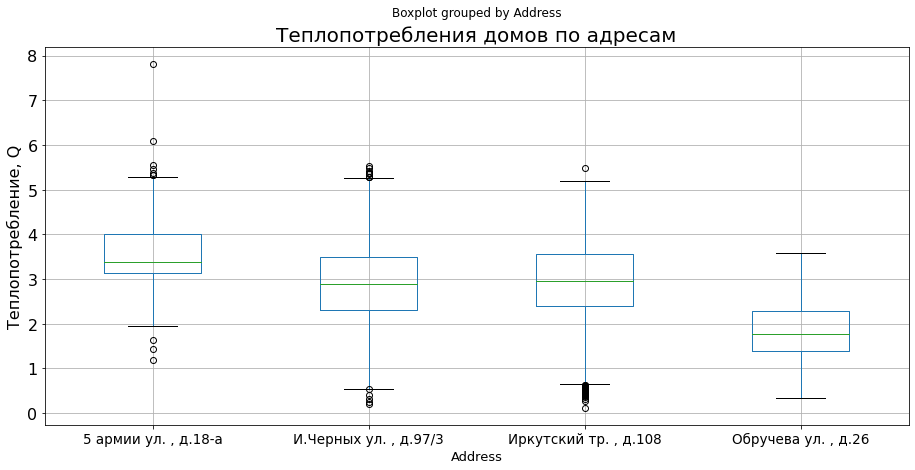

Средний Cyx для 5 армии ул. , д.18-а = 0.5953696033741288
Средний Cyx для И.Черных ул. , д.97/3 = 0.737897084685778
Средний Cyx для Иркутский тр. , д.108 = 0.6851171836207783
Средний Cyx для Обручева ул. , д.26 = 0.5895892205424023


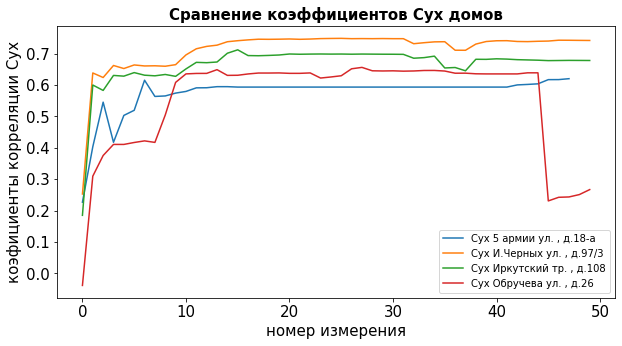

In [17]:
adresses3 = ['5 армии ул. , д.18-а', 'И.Черных ул. , д.97/3', 'Иркутский тр. , д.108', 'Обручева ул. , д.26']
boxplots_and_Cyx(adresses3, check_null=True)

Теперь будем рассматривать по одному дому и анализировать теплопотребление по USPD:

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


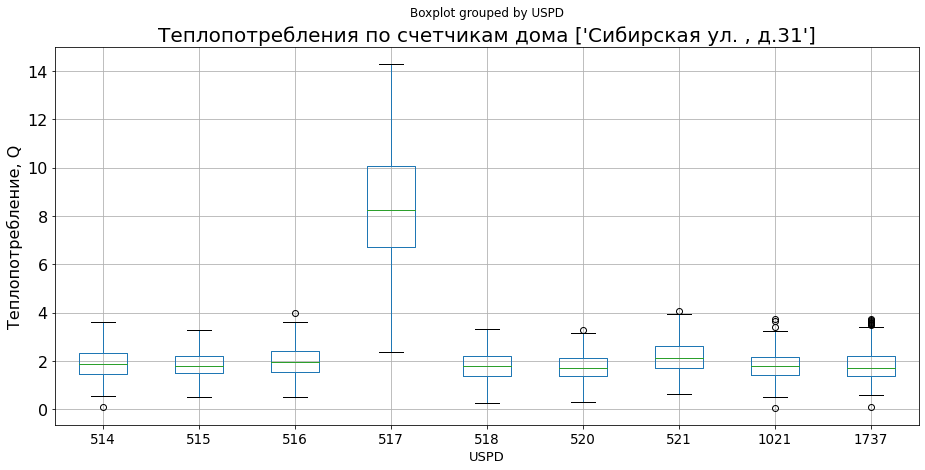

Средний Cyx для Сибирская ул. , д.31 = 0.37718847947143974


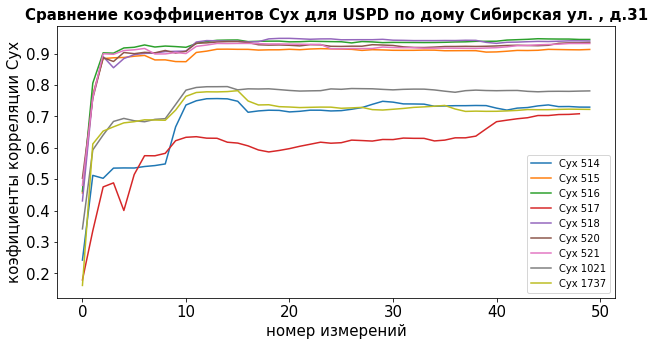

Средний Cyx для 514 = 0.732077003327661
Средний Cyx для 515 = 0.9105389745620183
Средний Cyx для 516 = 0.9393582214233499
Средний Cyx для 517 = 0.6388668239447792
Средний Cyx для 518 = 0.940918124507518
Средний Cyx для 520 = 0.9270918159774627
Средний Cyx для 521 = 0.9238073376516102
Средний Cyx для 1021 = 0.7848206821170272
Средний Cyx для 1737 = 0.7335838546547448


In [ ]:
adresses4 = ['Сибирская ул. , д.31']
boxplots_and_Cyx(adresses4, by=['USPD'], uspd=True)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


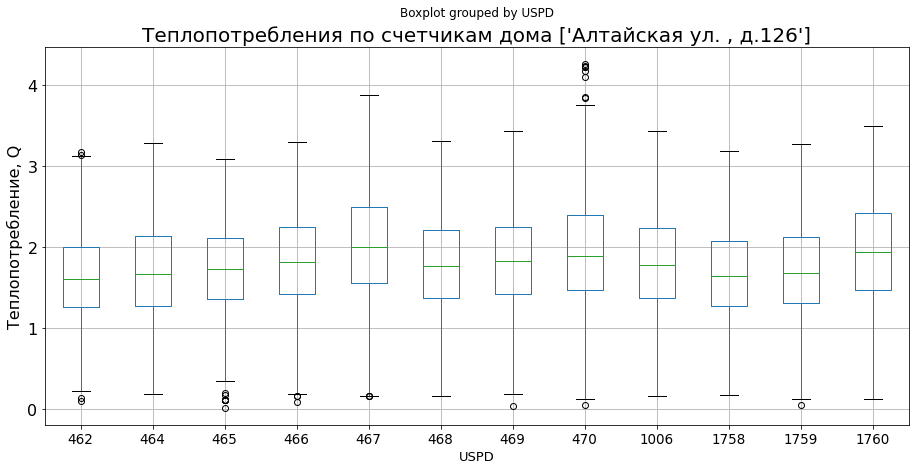

Средний Cyx для Алтайская ул. , д.126 = 0.3389057388924174


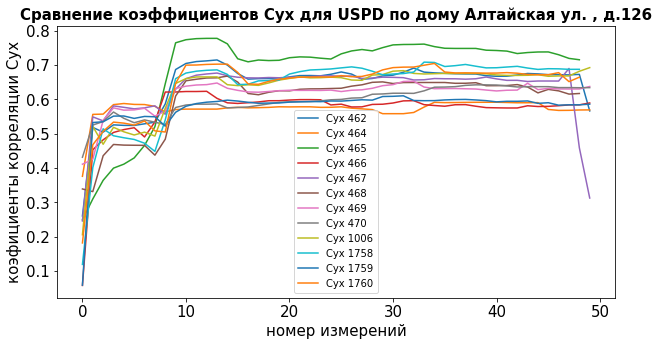

Средний Cyx для 462 = 0.6731572919994784
Средний Cyx для 464 = 0.5773295996537836
Средний Cyx для 465 = 0.7407435866964475
Средний Cyx для 466 = 0.5895158537851788
Средний Cyx для 467 = 0.6494928547475474
Средний Cyx для 468 = 0.6394770201181599
Средний Cyx для 469 = 0.6322261672999376
Средний Cyx для 470 = 0.6132194163536472
Средний Cyx для 1006 = 0.6666900694944692
Средний Cyx для 1758 = 0.6833965366929667
Средний Cyx для 1759 = 0.594210604478415
Средний Cyx для 1760 = 0.6766777639569675


In [ ]:
adresses5 = ['Алтайская ул. , д.126']
boxplots_and_Cyx(adresses5, by=['USPD'], check_null = True, uspd=True)
# check_null = True, т.к. данных по дому слишком много